## MF 728: Fixed Income

### Problem set # 2

#### 1. CDS Pricing Assume that the risk-free interest rate is 3% for all maturities and suppose that the CDS spreads for contracts that are starting today are given by the table below. Also, assume that the expected recovery R = 40%.
| Maturity | premium (bps) |
|------|----------|
| 1y   | 100   |
| 2y   | 110    |
| 3y   | 120    |
| 5y   | 140    |


##### (a) Assume that hazard rate is piecewise-constant and bootstrap the CDS survival curve using the information above.

In [96]:
from sympy import symbols, solve

def bootstrap_cds_survival_curve_optimized(recovery_rate, discount_factor, s1, s2, s3, s5):
    """
    Optimized function to bootstrap the CDS survival curve using given market spreads.
    
    :param recovery_rate: Recovery rate of the CDS.
    :param discount_factor: Discount factor based on the risk-free rate.
    :param s1, s2, s3, s5: Market spreads for 1, 2, 3, and 5 year CDS contracts.
    :return: A dictionary of solved survival probabilities for each maturity.
    """
    # Initialize symbols for probabilities
    p1, p2, p3, p5 = symbols('p1 p2 p3 p5')
    
    # Define equations based on market spreads and discount factors
    equations = [
        # Equation for 1 year CDS
        s1/2 * discount_factor * (p1 + 1) - (1 - recovery_rate) * discount_factor * (1 - p1),
        
        # Equation for 2 year CDS
        s2/2 * (discount_factor * (1 + p1) + discount_factor**2 * (p1 + p2)) - (1 - recovery_rate) * (discount_factor * (1 - p1) + discount_factor**2 * (p1 - p2)),
        
        # Equation for 3 year CDS
        s3/2 * (discount_factor * (1 + p1) + discount_factor**2 * (p1 + p2) + discount_factor**3 * (p2 + p3)) - (1 - recovery_rate) * (discount_factor * (1 - p1) + discount_factor**2 * (p1 - p2) + discount_factor**3 * (p2 - p3)),
        
        # Equation for 5 year CDS, including assumption for p4 as geometric mean of p3 and p5
        s5/2 * (discount_factor * (1 + p1) + discount_factor**2 * (p1 + p2) + discount_factor**3 * (p2 + p3) + discount_factor**4 * (p3 + p3*(p5/p3)**0.5) + discount_factor**5 * (p3*(p5/p3)**0.5 + p5)) - (1 - recovery_rate) * (discount_factor * (1 - p1) + discount_factor**2 * (p1 - p2) + discount_factor**3 * (p2 - p3) + discount_factor**4 * (p3 - p3*(p5/p3)**0.5) + discount_factor**5 * (p3*(p5/p3)**0.5 - p5))
    ]
    
    # Solve the system of equations for the survival probabilities
    solutions = solve(equations, (p1, p2, p3, p5))
    
    return solutions


In [97]:
recovery_rate = 0.4  
risk_free_rate = 0.03  
s1, s2, s3, s5 = 0.01, 0.011, 0.012, 0.014  

discount_factor = math.exp(-risk_free_rate)

solutions = bootstrap_cds_survival_curve_optimized(recovery_rate, discount_factor, s1, s2, s3, s5)

print("Survival Probabilities:", solutions)

Survival Probabilities: [(0.983471074380165, 0.963916788337287, 0.941435914039937, 0.888263456246023)]


In [99]:
import math
p1, p2, p3, p5 = survival_probabilities

def calculate_hazard_rates_from_probabilities(p1, p2, p3, p5):
    """
    Calculate hazard rates from given survival probabilities.
    
    :param p1, p2, p3, p5: Survival probabilities for 1, 2, 3, and 5 year terms.
    :return: A dictionary of hazard rates for each term.
    """
    terms = [1, 2, 3, 5]  
    probabilities = [p1, p2, p3, p5]  
    hazard_rates = {}
    
    for term, probability in zip(terms, probabilities):
        
        hazard_rate = -math.log(probability) / term
        hazard_rates[f'p{term}'] = hazard_rate
    
    return hazard_rates
    
hazard_rates = calculate_hazard_rates_from_probabilities(p1, p2, p3, p5)
print("Hazard Rates:", hazard_rates)



Hazard Rates: {'p1': 0.016667052485211987, 'p2': 0.018375153624747884, 'p3': 0.020116333711957163, 'p5': 0.023697379006101933}


##### (b) What would be a fair spread for a 4y CDS, that starts today.

In [103]:
from sympy import symbols, exp, solve
import math

def premium_leg(discount_factor, survival_probabilities, s4, recovery_rate):
    p1, p2, p3, p5 = survival_probabilities

    premium_leg_value = s4 * sum(exp(-discount_factor * t) * (p + q) / 2 for t, (p, q) in enumerate(zip([1, p1, p2, p3], [p1, p2, p3, p5]), start=1))
    return premium_leg_value

def protection_leg(discount_factor, survival_probabilities, recovery_rate):

    p1, p2, p3, p5 = survival_probabilities

    protection_leg_value = (1 - recovery_rate) * sum(exp(-discount_factor * t) * (p - q) for t, (p, q) in enumerate(zip([1, p1, p2, p3], [p1, p2, p3, p5]), start=1))
    return protection_leg_value


In [104]:
# 定义符号
s4 = symbols('s4')

premium_leg_value = premium_leg(discount_factor, survival_probabilities, s4, recovery_rate)
protection_leg_value = protection_leg(discount_factor, survival_probabilities, recovery_rate)

fair_spread_solution = solve(premium_leg_value - protection_leg_value, s4)

print("Fair Spread for 4-year CDS:", fair_spread_solution)


Fair Spread for 4-year CDS: [0.0116564562462268]


##### (c) If you had bought a 5y CDS exactly one year ago with the contractual spread of 80bps,what would you charge me to buy it off you today

In [105]:
import numpy as np

def calculate_contract_value(spread, survival_probabilities, maturities, discount_rate, recovery_rate):
    """
    Calculate the present value of a CDS contract based on remaining survival probabilities,
    spread, discount rate, and recovery rate for the remaining maturities.
    """
    discount_factors = np.exp(-discount_rate * maturities)
    
    premium_leg_value = np.sum(spread / 2 * (survival_probabilities[:-1] + survival_probabilities[1:]) * discount_factors[:-1])
    
    protection_leg_value = np.sum((1 - recovery_rate) * (survival_probabilities[:-1] - survival_probabilities[1:]) * discount_factors[:-1])
    
    return premium_leg_value - protection_leg_value


In [106]:
survival_probabilities = np.array([0.983471074380165, 0.963916788337287, 0.941435914039937, 0.888263456246023])

remaining_maturities = np.array([1, 2, 3, 4])

discount_factor = np.exp(-risk_free_rate * remaining_maturities)

contract_spread = 0.0080  # 80bps

contract_value = calculate_contract_value(contract_spread, survival_probabilities, remaining_maturities, risk_free_rate, recovery_rate)

print("Remaining Contract Value:", contract_value)


Remaining Contract Value: -0.03182062914796034


##### (d) Working with the 4y CDS in (1.b), compute the dv01 of the CDS with respect to the CDS curve in Table 1.

In [107]:
original_spread = fair_spread_4y

original_value = calculate_contract_value(original_spread, survival_probabilities, remaining_maturities, risk_free_rate, recovery_rate)

adjusted_spread = original_spread + 0.0001

adjusted_value = calculate_contract_value(adjusted_spread, survival_probabilities, remaining_maturities, risk_free_rate, recovery_rate)

dv01 = abs(adjusted_value - original_value)

print("DV01 of the 4-year CDS:", dv01)

DV01 of the 4-year CDS: 0.0002678223383351941


#### 2. Caplet Pricing in Different Models: 
Consider a 1Y expiry 1.25% strike put option on a 1Y3m forward rate, i.e., a forward rate with 3m tenor that starts 1Y from now. Recall that in the T-Forward measure the pricing equation for a caplet put option can be written as:

$$
P(K) = \delta D(0, T + \delta) \mathbb{E}\left[ (K - F_T)^+ \right]
$$

You may assume $\delta = 0.25$.


##### (a) Suppose you conducted a bootstrapping algorithm that identified the constant instantaneous forward rate over the entire period to be 1.25%. Calculate the discount factor needed to obtain the caplet price

In [108]:
from math import exp

r = 1.25 / 100  
T_delta = 1 + 0.25  # T + δ

D_0_T_delta = exp(-r * T_delta)

D_0_T_delta


0.9844964370054085

##### (b) Assume that the 1Y3m forward rate follows a log-normal distribution:
$$
dF_t = \sigma F_t \, dW_t
$$
and that σ = 0.15. You may assume a constant instantaneous forward rate of 1.25% when calculating the current forward rate, F0. Calculate the price of the option on the 1Y3m forward rate by adapting the Black-Scholes formula.

In [109]:
from math import log, sqrt
from scipy.stats import norm

sigma = 0.15  
K = 1.25 / 100  

F_0 = exp(r * T_delta) - 1

d_1 = (log(F_0 / K) + (0.5 * sigma ** 2) * T_delta) / (sigma * sqrt(T_delta))
d_2 = d_1 - sigma * sqrt(T_delta)

P_BS = D_0_T_delta * (K * norm.cdf(-d_2) - F_0 * norm.cdf(-d_1))

P_BS


8.90724821917334e-05

##### (c) Consider the Bachelier or Normal model:
$$
dF_t = \sigma_n \, dW_t
$$
Calculate what you believe to be the σn that will make the Normal model best approximate the Log-Normal model above

In [110]:
sigma_n = F_0 * sigma

sigma_n

0.0023621562880028588

##### (d) Using this σn, calculate the price of the put option defined above (1) under the Bachelier model. Compare to the Black-Scholes model price. Are they similar? Why or why not? Which one is higher? Why?

In [111]:
delta = 0.25

d_prime = (K - F_0) / (sigma_n * sqrt(T_delta))

P_Bachelier = delta * D_0_T_delta * ((K - F_0) * norm.cdf(d_prime) + sigma_n * sqrt(T_delta) * norm.pdf(d_prime))

P_Bachelier

P_Bachelier, P_BS


(3.429766455121045e-05, 8.90724821917334e-05)

Black-Scholes model gives a higher option price.  
The prices from the two models are not identical because they make different assumptions about the asset price dynamics:
- The **Black-Scholes model** assumes asset prices follow a lognormal distribution.    This means the asset price changes are percentage changes, so the absolute value of the changes increases with higher asset prices.    As a result, when asset prices or forward rates are higher, this model tends to show higher volatility, which can lead to higher option values.

- The **Bachelier model** assumes asset prices follow a normal distribution.    In this model, the asset price changes are fixed absolute amounts, independent of the current asset price.    Therefore, for low volatility or lower priced assets, the Bachelier model may provide more reasonable option pricing.


#### 3. Stripping Caplet Volatilities:

##### (a) Consider the following table of two-year at-the-money cap volatilities under the Black’s model:

| Start | Length Black |Black Vol |
|------|----------|----------|
| 1Y   |  2Y   |0.15   |
| 2Y   |  2Y    |0.2   |
| 3Y   |  2Y    |0.225   |
| 4Y   |  2Y    |0.225   |
| 5Y   |  2Y    |0.25   |

Assume that caplets are paid quarterly on three-month forward rates each with δ = 0.25. Further assume a flat interest rate curve with 1% instantaneous forward rates along the entire curve. Calculate the price of each cap using Black’s model.

In [112]:
# Constants
delta = 0.25  # Tenor of each caplet
r = 0.01  # Flat interest rate curve
F = 0.01  # Forward rate
K = 0.01  # Strike rate, at-the-money

# Black volatilities and start periods
black_vols = [0.15, 0.2, 0.225, 0.225, 0.25]
start_years = [1, 2, 3, 4, 5]  # Start periods for each cap

# Function to calculate the price of a caplet using Black's model
def caplet_price(sigma, T):
    d1 = (np.log(F/K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    P_t_T = np.exp(-r * T)  # Present value factor
    price = delta * P_t_T * (F * norm.cdf(d1) - K * norm.cdf(d2))
    return price

# Calculate the price of each cap by summing the prices of its caplets
cap_prices = []
for i, vol in enumerate(black_vols):
    T = start_years[i]  # Time to maturity for the caplets in the cap
    # Number of caplets in the cap
    num_caplets = 4 * 2  # 4 quarters per year, over 2 years
    cap_price = sum([caplet_price(vol, T + j*delta) for j in range(num_caplets)])
    cap_prices.append(cap_price)

cap_prices


[0.001584212393016439,
 0.002601553278139788,
 0.0033610515141422265,
 0.0037287863450408396,
 0.0044833720099149675]

##### (b) Extract the Black-Scholes at-the-money implied volatilities for each caplet from the provided set of cap volatilities. Comment on the shape of the caplet vs. cap volatilities.

In [113]:
def discount(begin,end,f):
    return np.exp(-(end-begin)*f)
    
def bsfac(f0,k,sigma,t):
    d1 = (np.log(f0/k) + 0.5 * sigma**2 * t)/sigma/t**0.5
    d2 = (np.log(f0/k) - 0.5 * sigma**2 * t)/sigma/t**0.5
    prep =  0.25 * (k * norm.cdf(-d2) - f0 * norm.cdf(-d1) )

    return prep
    
def caplet_vol(nsigma,price,head,osigma):
    price1 = 0
    price2 = 0
    for i in range(4):
        price1 = price1 + discount(0,head-1+(i-1)*0.25,f) * bsfac(f0,k,osigma,head-1+i*0.25)
        price2 = price2 + discount(0,head+(i-1)*0.25,f) * bsfac(f0,k,nsigma,head+i*0.25)
        
    return price1 + price2 - price

def root_vol(fir_sigma,price):
    volst = [fir_sigma]
    sigma = fir_sigma
    for i in range(3,7):
        func = root(caplet_vol,sigma,args=(price[i-2],i,sigma))
        sigma = func.x[0]
        volst += [sigma]
    
    
    return volst

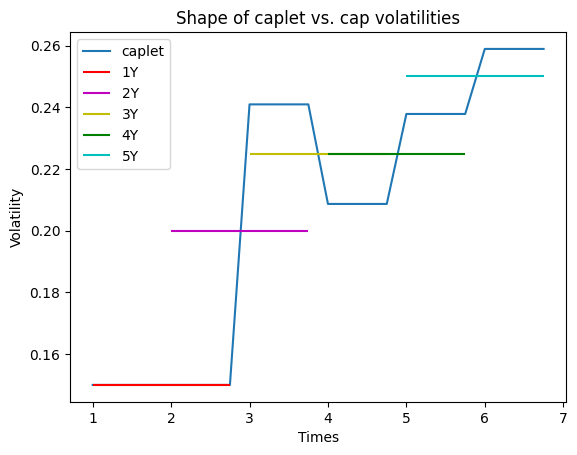

In [114]:
#visualize
t = np.linspace(1, 7, 24, endpoint = False)
caplet = np.repeat(np.array(volst), [8, 4, 4, 4, 4], axis = 0)
caps = [0.15,0.2,0.225,0.225,0.25]

plt.title("Shape of caplet vs. cap volatilities")
plt.xlabel("Times")
plt.ylabel("Volatility")
plt.plot(t, caplet, label = "caplet")
plt.hlines(caps[0], xmin = 1, xmax = 2.75, color = 'r',label = "1Y")
plt.hlines(caps[1], xmin = 2, xmax = 3.75, color = 'm',label = "2Y")
plt.hlines(caps[2], xmin = 3, xmax = 4.75, color= 'y',label = "3Y")
plt.hlines(caps[3], xmin = 4, xmax = 5.75, color = 'g',label = "4Y")
plt.hlines(caps[4], xmin = 5, xmax = 6.75, color = 'c',label = "5Y")
plt.legend()

1. **Stair-step Pattern for Caplets**: The volatility of the caplet shows a stair-step pattern, which suggests that the volatility changes at discrete points in time rather than continuously. 

2. **Flat Lines for Caps**: The lines representing the cap volatilities for 1Y, 2Y, 3Y, 4Y, and 5Y are flat, indicating that the cap volatilities for these maturities are constant over time.

3. **Differences Between Caplet and Cap Volatilities**: The plot may suggest that the volatility surface is not flat and that the market is pricing in different volatilities for different reset periods. The fact that cap volatilities are flat across different maturities might suggest that the market is not expecting significant changes in volatility over the long term, or that it is averaging out the variations seen in the short-term caplet volatilities.
